In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install scikit-image
!apt-get update
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install opencv-python

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
Hit:1 http://deb.debian.org/debian buster InRelease
Hit:2 http://deb.debian.org/debian buster-updates InRelease
Hit:3 http://security.debian.org/debian-security buster/updates InRelease




ffmpeg is already the newest version (7:4.1.8-0+deb10u1).
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
from time import time
from itertools import product
import imageio
from tqdm import tqdm

import numpy as np
import cv2
import pandas as pd

from optical_flow import block_matching_flow
from utils import OpticalFlow #, load_optical_flow
from evaluation import eval_opticalflow

In [2]:
def load_optical_flow(img_path):
        flow_data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype('float')
        mask = (flow_data[:,:,0]).astype('bool')
        v = (flow_data[:,:,1] - 2**15)/64
        u = (flow_data[:,:,2] - 2**15)/64

        return mask, u, v


In [3]:
# Optical Flow with Block Matching
img_prev = cv2.imread('imgs/000045_10.png', cv2.IMREAD_GRAYSCALE)
img_next = cv2.imread('imgs/000045_11.png', cv2.IMREAD_GRAYSCALE)

# Image 157
mask, u_gt, v_gt = load_optical_flow('imgs/000045_10_gt.png')
_, u, v = load_optical_flow('imgs/LKflow_000045_10.png')


In [4]:
import math

def matching_cost(patch1, patch2, kind="ssd"):
    if kind == "ssd":
        return np.sum( (patch1.astype(np.float32)-patch2.astype(np.float32))**2 )
    elif kind == "sad":
        return np.sum( np.abs(patch1.astype(np.float32)-patch2.astype(np.float32)) )
    elif kind == "ncc":
        patch1 = patch1.astype(np.float32)
        patch2 = patch2.astype(np.float32)
        epsilon = 1e-6
        mean_I1 = np.mean(patch1)
        mean_I2 = np.mean(patch2)
        std_I1 = max(np.sqrt(np.sum((patch1 - mean_I1)**2)), epsilon)
        std_I2 = max(np.sqrt(np.sum((patch2 - mean_I2)**2)), epsilon)
        cost = np.sum((patch1 - mean_I1)*(patch2 - mean_I2)) / (std_I1*std_I2)
        return -cost
    else:
        raise Exception("Not found")

def block_matching_flow(img_prev, img_next, block_size, search_area, step_size, motion_type, kind):
    """
    Compute block-matching based motion estimation
    """

    if motion_type == 'forward':
        reference = img_prev
        target = img_next

        height, width = reference.shape[:2]
        flow_field = np.zeros((height, width, 2), dtype=float)

        blocks_list = []
        width = img_prev.shape[1]
        height = img_prev.shape[0]

        # For each block in the reference image
        for i in range(0, width, block_size):
            for j in range(0, height, block_size):
                if reference.shape[0] > block_size+j and reference.shape[1] > block_size+i: 
                    #print(j,block_size+j, i,block_size+i)
                    block = reference[j:block_size+j, i:block_size+i]
                    
                    # Search in the target image
                    us = [u for u in np.arange(-search_area//2, search_area//2 + 1, step_size) if 0 <= u+i < target.shape[1] and 0 <= u+i+block_size < target.shape[1]]
                    vs = [v for v in np.arange(-search_area//2, search_area//2 + 1, step_size) if 0 <= v+j < target.shape[0] and 0 <= v+j+block_size < target.shape[0]]
                    
                    min_cost = math.inf
                    opt_u, opt_v = None, None
                    for u in us:
                        for v in vs:
                            block_to_compare = target[j+v:block_size+j+v, i+u:block_size+i+u]
                            #print(block.shape, block_to_compare.shape)
                            cost = matching_cost(block, block_to_compare, kind)
                            if cost < min_cost:
                                min_cost = cost
                                opt_u, opt_v = u, v
                    
                    # Assign optical flow to block u / v order?
                    flow_field[j:block_size+j, i:block_size+i, 0] = opt_u
                    flow_field[j:block_size+j, i:block_size+i, 1] = opt_v

    elif motion_type == 'backward':
        reference = img_next
        target = img_prev

        height, width = reference.shape[:2]
        flow_field = np.zeros((height, width, 2), dtype=float)

        blocks_list = []
        width = img_prev.shape[1]
        height = img_prev.shape[0]

        # For each block in the reference image
        for i in range(0, width, block_size):
            for j in range(0, height, block_size):
                if reference.shape[0] > block_size+j and reference.shape[1] > block_size+i: 
                    #print(j,block_size+j, i,block_size+i)
                    block = reference[j:block_size+j, i:block_size+i]
                    
                    # Search in the target image
                    us = [u for u in np.arange(-search_area//2, search_area//2 + 1, step_size) if 0 <= u+i < target.shape[1] and 0 <= u+i+block_size < target.shape[1]]
                    vs = [v for v in np.arange(-search_area//2, search_area//2 + 1, step_size) if 0 <= v+j < target.shape[0] and 0 <= v+j+block_size < target.shape[0]]
                    
                    min_cost = math.inf
                    opt_u, opt_v = None, None
                    for u in us:
                        for v in vs:
                            block_to_compare = target[j+v:block_size+j+v, i+u:block_size+i+u]
                            #print(block.shape, block_to_compare.shape)
                            cost = matching_cost(block, block_to_compare)
                            if cost < min_cost:
                                min_cost = cost
                                opt_u, opt_v = u, v
                    
                    # Assign optical flow to block u / v order?
                    flow_field[j-opt_u:block_size+j-opt_u, i-opt_v:block_size+i-opt_v, 0] = -opt_u
                    flow_field[j-opt_u:block_size+j-opt_u, i-opt_v:block_size+i-opt_v, 1] = -opt_v

    return flow_field

In [12]:

motion_types = ['forward', 'backward']
search_areas = [2**i for i in range(4, 8)]
block_sizes = [2**i for i in range(2, 6)]
step_sizes = [1, 3, 5, 7, 9, 11, 13]
kinds = ['ssd', 'sad', 'ncc']

#motion_types = ["backward"]

# motion_types = ["forward", "backward"]
# search_areas = [16,24]
# block_sizes = [16]
# step_sizes= [1]
# kinds = ['ssd']

data = []
for motion_type, search_area, block_size, step_size, kind in product(motion_types, search_areas, block_sizes, step_sizes, kinds):
    t0 = time()
    # Estimate block matching with: motion_type, search_area, block_size
    flow = block_matching_flow(img_prev, img_next, block_size, search_area, step_size, motion_type, kind)
    u, v = flow[:,:,0], flow[:,:,1]
    t1 = time()
    msen, pepn = eval_opticalflow(u, v, u_gt, v_gt, mask)
    display_OpticalFlow(img_prev, u, v, f"results/arrows_seq045_m{motion_type}_s{search_area}_b{block_size}_st{step_size}_k{kind}.png", "arrows", divisor=16, plot=False)
    print(msen, pepn)
    data.append([motion_type, search_area, block_size, step_size, kind, t1 - t0, msen, pepn])

df = pd.DataFrame(data, columns=["motion_type", "search_area", "block_size","step_size","kind", "exe_time", "msen", "pepn"])
df.to_csv("results.csv", index=None, sep=',')

206.12930112458665 0.7348701236461229
208.32194705576657 0.7503115115498897
227.89028250578093 0.6719160356560913
220.03726174233802 0.8136585833413208
221.35738898282494 0.8169078884309403
252.26311839910022 0.830691076392217
232.62252994180125 0.877944982267804
233.3053572685529 0.8773411291095562
265.65155443140156 0.8932521805808492
238.07352797688225 0.897019074091824
237.75623878633303 0.8965014856704687
273.36553081642984 0.9134572989552382
264.94925823184246 0.8452027221316974
264.9886542588721 0.8455381961085019
291.3535732658691 0.8686475606249401
256.95165866795867 0.904351576727691
257.11610381796345 0.9057126425764401
290.72663320788007 0.930336432473881
256.8320172656774 0.9376881050512796
255.1138130099504 0.9371130068053293
301.0519345353985 0.9533211923703633
184.80942968300704 0.585162465254481
187.4667085697127 0.6151442538100259
196.58456237494607 0.4283715134668839
206.5525677425297 0.7083485095370459
205.46631768262364 0.7154509728745327
229.75623908586337 0.65717

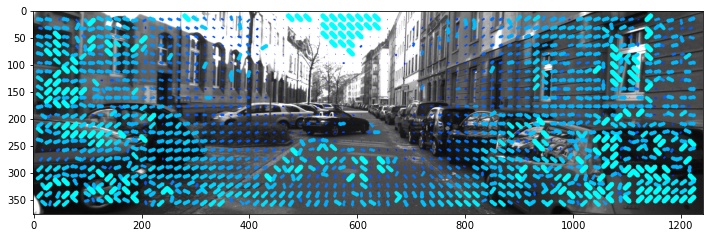

In [10]:
#from utils import display_OpticalFlow

display_OpticalFlow(img_prev, u, v, 'arrows_seq045_test.png', "arrows", divisor=block_size, plot=True)

In [9]:
# Write pandas dataframe with result
# motion_type = forward / backward, search_area = int, block_size = int, msen, pepn, runtime
df = pd.DataFrame(data, columns=["motion_type", "search_area", "block_size", "exe_time", "msen", "pepn"])
df.to_csv("results.csv", index=None, sep=' ')

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

def display_OpticalFlow(image, u, v, name, type_plot, divisor=3, h_parts=14, v_parts=4, plot=False):
    """
    Save image with a visualisation of a flow over the top.
    A divisor controls the density of the quiver plot.

    Args:
        image (cv2): imatge over which we want to plot the Optical Flow.
        u,v (HxW arrays): Optical Flow that we want to display over the image.
        name (str): path where to save the image with the Optical Flow over it.
        type_plot (str): "arrows", "color_wheel" or "simplification".
        divisor (int): every how many pixels we want to display the Optical Flow vector.
                        Used in type_plot="arrows".
        h_parts (int): number of horizontal cells to divide the image. Used in type_plot="simplification".
        v_parts (int): number of vertical cells to divide the image. Used in type_plot="simplification".
        plot (bool): if we want to display the plots or not.
    """
    flow = np.dstack((u,v))
    if type_plot == "arrows":
        OpticalFlow_arrows(image, flow, divisor, name)
    elif type_plot == "color_wheel":
        flow_color = flow_vis.flow_uv_to_colors(u, v, convert_to_bgr=False)
        blend_imgs(image, flow_color, name)
    elif type_plot == "simplification":
        OpticalFlow_simplification(image, u, v, h_parts, v_parts, name)
    else:
        print('ERROR: Incorrect plot type. Options: arrows or color_wheel.')

    if plot:
        flow_image = Image.open(name)
        plt.figure(figsize=(12,4))
        plt.imshow(flow_image)


def OpticalFlow_arrows(image, flow, divisor, name):
    """
    Save image with a visualisation of a flow over the top.
    A divisor controls the density of the quiver plot.

    Args:
        image (cv2): imatge over which we want to plot the Optical Flow.
        flow (HxWx2 array): Optical Flow that we want to display over the image. Format: np.dstack((u,v))
        divisor (int): every how many pixels we want to display the Optical Flow vector.
        name (str): path where to save the image with the Optical Flow over it.
    """
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    picture_shape = np.shape(image)
    # determine number of quiver points there will be
    Imax = int(picture_shape[0]/divisor)
    Jmax = int(picture_shape[1]/divisor)

    max_val = np.sqrt(np.max(flow[:,:,0].reshape(-1)**2 + flow[:,:,1].reshape(-1)**2))

    # draw the arrows into the image
    for i in range(1, Imax):
        for j in range(1, Jmax):
            X1 = (i)*divisor
            Y1 = (j)*divisor
            X2 = int(X1 + flow[X1,Y1,1])
            Y2 = int(Y1 + flow[X1,Y1,0])
            X2 = np.clip(X2, 0, picture_shape[0])
            Y2 = np.clip(Y2, 0, picture_shape[1])

            magnitude = np.sqrt(flow[X1,Y1,1]**2 + flow[X1,Y1,0]**2)
            col = int(255 * (magnitude / max_val))
            
            #add all the lines to the image
            image = cv2.arrowedLine(image, (Y1,X1),(Y2,X2), [255, col, 0], int(1 + 6*(col/255)))

    cv2.imwrite(name, image)

In [35]:
flow_data = np.load('/home/aszummer/Documents/MCV/M6/mcvm6team3/week4/pyflow/examples/outFlow.npy')

In [36]:
display_OpticalFlow(img_prev, flow_data[:,:,0], flow_data[:,:,1], f"pyflow_4.png", "arrows", divisor=16, plot=False)

In [37]:
msen, pepn = eval_opticalflow(flow_data[:,:,0], flow_data[:,:,1], u_gt, v_gt, mask)
msen, pepn

(7.6107671649304125, 0.14511645739480494)

In [26]:
flow_data = np.load('/home/aszummer/Documents/MCV/M6/mcvm6team3/week4/MaskFlownet/flow.npy')

In [29]:
msen, pepn = eval_opticalflow(flow_data[:,:,0], flow_data[:,:,1], u_gt, v_gt, mask)
msen, pepn

(3.372019361508087, 0.04551902616697019)

In [28]:
display_OpticalFlow(img_prev, flow_data[:,:,0], flow_data[:,:,1], f"maskflownet_2.png", "arrows", divisor=16, plot=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=509078b5-6b9c-43ed-9cfa-40f4216bf5cd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>